In [1]:
from collections import Counter
import json
from math import log
import numpy as np
from nltk.stem import PorterStemmer
from tqdm import tqdm

np.random.seed(0)

In [15]:
def bag_of_words(text, dictionary):
    bag = [0] * len(dictionary)
    for word in text:
        if word in dictionary:
            bag[dictionary[word]] += 1

    return bag

def generate_dictionary(subcategory_questions):
    """
    Generate dictionary for bag of words
    """

    dictionary = set()
    for subcat in subcategory_questions:
        for question in subcategory_questions[subcat]:
            dictionary.update(question)

    dictionary = list(dictionary)
    dictionary = {dictionary[i]: i for i in range(len(dictionary))}
    return dictionary

def naive_bayes(vector, sparse_encodings):
    counts = {
        subcat: {word_index: 0 for word_index in vector}
        for subcat in sparse_encodings
    }

    for subcat in sparse_encodings:
        for x in sparse_encodings[subcat]:
            for word_index in x:
                if word_index in vector and vector[word_index] == x[word_index]:
                    counts[subcat][word_index] += 1

    sums = {
        subcat: log(len(sparse_encodings[subcat])) + sum([log(counts[subcat][word_index]) for word_index in counts[subcat] if counts[subcat][word_index] > 0])
        for subcat in counts
    }

    return max(sums, key=sums.get)

def naive_bayes_from_summary(vector, summary, class_priors, subcategories):
    token_counter = Counter(vector)

    counts = {
        # subcat: [summary[token][subcat][token_counter[token]]/sum(summary[token][subcat].values()) for token in token_counter if token in summary and token_counter[token] in summary[token][subcat]]
        subcat: [summary[token][subcat][token_counter[token]] for token in token_counter if token in summary and token_counter[token] in summary[token][subcat]]
        for subcat in subcategories
    }

    sums = {
        subcat: log(class_priors[subcat]) + sum([log(count) for count in counts[subcat] if count > 0])
        for subcat in counts
    }

    return max(sums, key=sums.get)

def sparse_bag_of_words(text, dictionary):
    """
    Generate a sparse bag of words.
    Has the same effect as calling `sparsify(bag_of_words(text, dictionary))`, but is much more memory and time efficient.
    """

    bag = {dictionary[word]: 0 for word in text if word in dictionary}
    for word in text:
        if word in dictionary:
            bag[dictionary[word]] += 1

    return bag

def sparsify(vector):
    return {index: count for index, count in enumerate(vector) if not count == 0}

def removePunctuation(s, punctuation='''.,!-;:'"\/?@#$%^&*_~()[]{}“”‘’'''):
    return ''.join(ch for ch in s if ch not in punctuation)

In [3]:
ps = PorterStemmer()

with open('../stop-words.txt') as f:
    stop_words = set(f.readlines())
    stop_words = set([word.strip() for word in stop_words])

with open('../subcategories.txt') as f:
    SUBCATEGORIES = [line.strip() for line in f.readlines()]

questions = open('questions.json')
questions = questions.readlines()
np.random.shuffle(questions)

In [4]:
subcategory_questions = {subcat: [] for subcat in SUBCATEGORIES}
naive_bayes_data = {}
class_priors = {subcat: 0 for subcat in SUBCATEGORIES}

for line in tqdm(questions[int(0.2*len(questions)):]):
    data = json.loads(line)

    if 'subcategory' not in data: continue
    subcategory = data['subcategory']
    if subcategory not in SUBCATEGORIES: continue

    if data['type'] == 'tossup':
        tokens = removePunctuation(data['question']).lower().split()
    if data['type'] == 'bonus' and 'parts' in data and len(data['parts']) == 3:
        tokens = removePunctuation(data['leadin'] + ' ' + data['parts'][0] + data['parts'][1] + data['parts'][2]).lower().split()

    tokens = [token for token in tokens if token not in stop_words]
    tokens = [ps.stem(token) for token in tokens]

    token_counter = Counter(tokens)

    for token in tokens:
        if token not in naive_bayes_data:
            naive_bayes_data[token] = {subcat: {} for subcat in SUBCATEGORIES}

        naive_bayes_data[token][subcategory][token_counter[token]] = naive_bayes_data[token][subcategory].get(token_counter[token], 0) + 1

    class_priors[subcategory] += 1

    # subcategory_questions[subcategory].append(tokens)

100%|██████████| 133648/133648 [02:46<00:00, 804.20it/s]


In [5]:
# dictionary = generate_dictionary(subcategory_questions)
# print('Size of dictionary:', len(dictionary), 'words')

In [6]:
# encodings = {
#     subcat: [bag_of_words(question, dictionary) for question in tqdm(subcategory_questions[subcat])]
#     for subcat in SUBCATEGORIES
# }

In [7]:
# encodings_sparse = {
#     subcat: [sparse_bag_of_words(vector, dictionary) for vector in tqdm(subcategory_questions[subcat])]
#     for subcat in SUBCATEGORIES
# }

In [19]:
import seaborn as sn
from sklearn.metrics import ConfusionMatrixDisplay
import time

print('=====Begin Testing=====')
time_now = time.perf_counter()

counter = 0
correct = 0
confusion_matrix = [
    [0 for _ in range(len(SUBCATEGORIES))]
    for _ in range(len(SUBCATEGORIES))
]

for line in questions[:int(0.2*len(questions))]:
    data = json.loads(line)
    if 'subcategory' not in data:
        continue

    counter += 1
    subcategory = data['subcategory']
    if subcategory not in SUBCATEGORIES:
        continue

    if data['type'] == 'tossup':
        text = data['question']
    elif data['type'] == 'bonus' and 'parts' in data and len(data['parts']) == 3:
        text = data['leadin'] + ' ' + data['parts'][0] + data['parts'][1] + data['parts'][2]
    else:
        continue

    text = removePunctuation(text).lower().split()
    tokens = [token for token in text if token not in stop_words]
    tokens = [ps.stem(token) for token in tokens]
    prediction = naive_bayes_from_summary(tokens, naive_bayes_data, class_priors, SUBCATEGORIES)
    subcategory_index = SUBCATEGORIES.index(subcategory)
    prediction_index = SUBCATEGORIES.index(prediction)

    confusion_matrix[subcategory_index][prediction_index] += 1

    if subcategory == prediction:
        correct += 1

    if counter % 10000 == 0:
        print(f'{correct}/{counter}')

print('=====End Testing=====')
print(f'Accuracy: {correct / counter} ({correct}/{counter})')
print('Time:', time.perf_counter() - time_now, 'seconds')

=====Begin Testing=====
6697/10000
13445/20000
20133/30000
=====End Testing=====
Accuracy: 0.6727447794427394 (22358/33234)
Time: 66.06431898201117 seconds


In [20]:
print('Confusion Matrix:')
for subcat, row in zip(SUBCATEGORIES, confusion_matrix):
    print(f'{subcat:20}', row)

Confusion Matrix:
American Literature  [1555, 47, 0, 16, 7, 0, 42, 0, 27, 7, 0, 0, 1, 2, 0, 0, 13, 7, 0, 3, 7, 11, 10, 0, 1, 0, 0]
British Literature   [302, 1099, 0, 10, 0, 0, 11, 0, 50, 3, 0, 0, 0, 0, 0, 0, 8, 7, 0, 4, 9, 9, 1, 0, 1, 0, 0]
Classical Literature [38, 27, 0, 1, 3, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 29, 4, 0, 0, 0, 0, 0]
European Literature  [365, 80, 0, 654, 6, 0, 4, 0, 51, 2, 0, 0, 0, 1, 0, 2, 16, 10, 0, 2, 12, 7, 1, 0, 1, 0, 0]
World Literature     [600, 50, 0, 13, 232, 0, 13, 0, 24, 26, 0, 0, 0, 2, 0, 1, 9, 4, 0, 1, 22, 2, 1, 0, 1, 0, 0]
Other Literature     [151, 62, 0, 9, 8, 0, 8, 0, 5, 4, 0, 1, 0, 0, 0, 1, 2, 6, 0, 0, 4, 4, 1, 0, 0, 0, 0]
American History     [38, 2, 0, 1, 1, 0, 1623, 0, 129, 49, 0, 0, 0, 1, 0, 3, 7, 2, 1, 3, 2, 2, 4, 0, 6, 0, 0]
Ancient History      [4, 2, 0, 0, 0, 0, 7, 3, 414, 56, 0, 0, 0, 1, 0, 1, 10, 0, 0, 6, 9, 0, 1, 0, 1, 0, 0]
European History     [24, 15, 0, 1, 0, 0, 75, 0, 2142, 52, 0, 2, 1, 5, 0, 1, 17, 4, 0, 4, 5, 4, 6, 0, 6,

<AxesSubplot:>

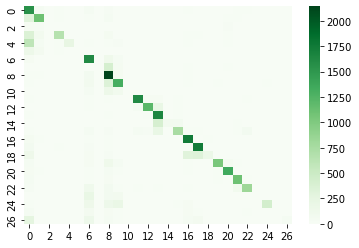

In [21]:
sn.heatmap(confusion_matrix, cmap='Greens', annot=False)